In [1]:
## This script is to plot probability of rain
## Revised by C. Bayu Risanto, S.J. (6 December 2023)
import warnings
warnings.filterwarnings('ignore')
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import xarray as xr
import time
def read_latlon(path,ncfile):
    fname = path + ncfile
    ds = Dataset(fname,'r')
    lat = ds.variables['XLAT'][0,:,:]
    lon = ds.variables['XLONG'][0,:,:]
    return lat,lon

In [2]:
# Open the NetCDF file
path = '/net/brisa/br1/castrogroup/bayu/ARABIA/wrfout.extract/S2S-WRF/2023-11-02/'
ds = Dataset(path + "/Rain.2023-11-02.nc")
prnc = ds.variables['RAINNC'][:,:,:,:]
dataset = xr.open_dataset(path + 'Rain.2023-11-02.nc')
pr = dataset['RAINNC']

link = '/net/brisa/br1/castrogroup/bayu/ARABIA/wrfout.extract/S2S-WRF/2023-10-05/'
latlonf = 'latlon.nc'
lats,lons = read_latlon(link,latlonf)

masklk = '/net/brisa/br1/castrogroup/bayu/ARABIA/wrfout.extract/S2S-WRF/2023-10-05/'
dmask = Dataset(masklk + 'mask.nc')
dm = dmask.variables['__xarray_dataarray_variable__'][:,:]
m = dm.astype('float')
m[m==0] = np.nan

In [3]:
nens,nweek,ny,nx = pr.shape
print(pr.shape,lons.shape,lats.shape)

(51, 6, 671, 767) (671, 767) (671, 767)


In [4]:
## compute percentage beyond threshold in mm
thres = 1
prb = []
for iw in range(6):
    r_thresh = prnc[:,iw,:,:].copy()
    r_thresh[r_thresh < thres] = False
    r_thresh[r_thresh >= thres] = True
    r_tn = r_thresh.copy()
    r_tn[r_tn > 0] = 1
    r_sum = np.nansum(r_tn,axis=0)
    prob = 100 * (r_sum / nens)*m
    prb.append(prob)
PROB = np.array(prb)
print(PROB.shape)

(6, 671, 767)


In [5]:
## compute the ens mean
ens_mean = xr.where(pr>thres,pr,np.nan)*m
emean = np.mean(ens_mean,axis=0)
print(emean.shape)

(6, 671, 767)


In [6]:
# Create precip color map
nws_precip_colors = [
    "#fdfdfd",  # 10.00+
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6"  # 8.00 - 10.00 inches
]
precip_colormap = mpl.colors.ListedColormap(nws_precip_colors)

In [7]:
# Create a figure PROBABILITY
def plot_prob(prec,r,thres,unit,levels):
    cart_proj = ccrs.PlateCarree()
    fig,axe = plt.subplots(2,3,figsize=(18,12),subplot_kw={'projection':cart_proj})
    
    axlist = axe.flatten()
    ct = 0
    for ax1 in axlist:
        norm = mpl.colors.BoundaryNorm(levels, 15)

    # Download and add the states and coastlines
        ax1.add_feature(cf.BORDERS,zorder=3)
        ax1.add_feature(cf.STATES,zorder=3)
        ax1.add_feature(cf.COASTLINE,zorder=3)
        ax1.coastlines('10m', linewidth=0.8)

    # plot here
        p0 = axlist[ct].pcolormesh(lons, lats, prec[ct,:,:],
                         transform=ccrs.PlateCarree(),
                         cmap=precip_colormap, norm=norm)
    
    # Set the map bounds
        ax1.set_xlim(31.28, 61.26)
        ax1.set_ylim(9.69, 33.56)
    
    ## get loc markers
        lonc = [39.85,39.61,46.71,41.68,36.57,44.13,49.9]
        latc = [21.38,24.47,24.63,27.51,28.39,17.49,26.4]
        city = ['Mecca','Madinah','Riyadh','Hail','Tabuk','Najran','Dammam']
        for ic in range(len(city)):
            lat_loc = latc[ic]
            lon_loc = lonc[ic]
            ax1.plot(lon_loc,lat_loc, marker='o', markerfacecolor='none',
                 markeredgecolor='k', markersize=3, transform=projection,zorder=11)
            ax1.annotate(city[ic],(lon_loc-0.5,lat_loc+0.3),fontsize=6, fontname='serif',)
    
    ## title
        t0 = axlist[ct].set_title('week '+str(ct+1),
                            loc='center',pad=7,fontsize=18)
    
    ## Add the gridlines
        ax1.gridlines(color='black', linestyle='dotted')
        ct += 1
    
    #fig.tight_layout()
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.16, 
                    wspace=0.07, 
                    hspace=-0.58)
    # Add a color bar
    fig.colorbar(p0,ax=axe,shrink=.5,ticks=levels,aspect=40,pad=-0.05,anchor=(0.5,0.5))

    fig.suptitle(str(r)+' of rainfall > '+str(thres)+' mm/week',fontsize=18,x=0.46)
    dir_out = '/home/bayu/Documents/Arabia_Project/PLOTS_S2S/S2S_oper/WRF/20231102/'
    plt.show()
    fig.savefig(dir_out+'RAINNC_PROB_n_MEAN/'+str(thres)+'_mm/'+
                    'P_alltime_e'+str(r)+'_'+str(thres)+'mm.png',bbox_inches='tight', dpi=200)
    plt.close()

levels = [0, 1, 2, 4, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
norm = mpl.colors.BoundaryNorm(levels, 15)
projection = ccrs.PlateCarree()

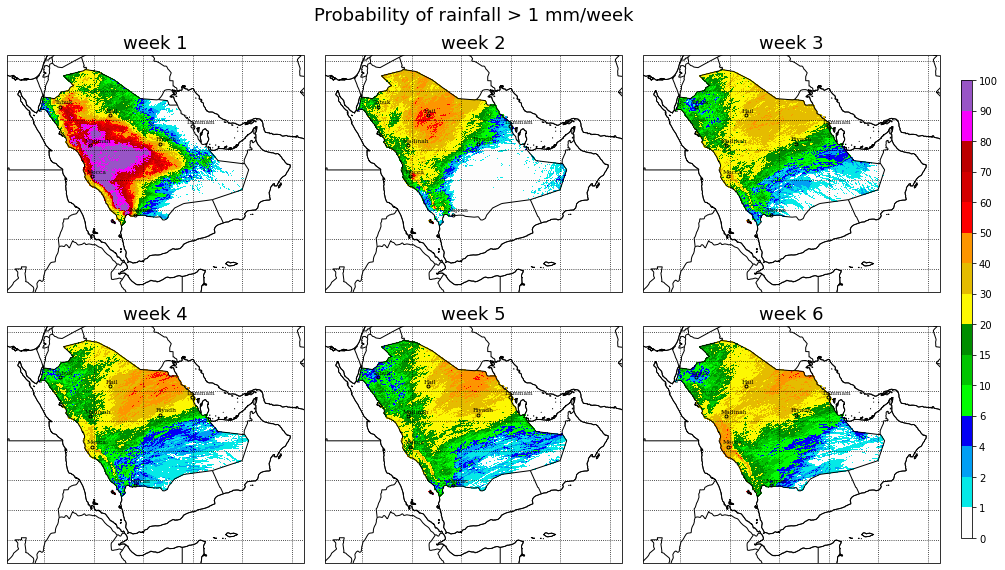

In [8]:
## plot
plot_prob(PROB,'Probability',thres,' (%)',levels)

In [9]:
ecmwf_colors = ['#ffffff','#24e1ee','#1380ee','#2531f5','#f8c4f0','#c741cd','#f805a0',
               '#f0d330','#d6a639','#EE6A24','#ff0000']
pecmwf_colormap = mpl.colors.ListedColormap(ecmwf_colors)
levels = [0, 1, 2, 4, 10, 15, 20, 25, 40, 60, 100, 200]
norm_new = mpl.colors.BoundaryNorm(levels, 12)

In [10]:
# Create a figure MEAN Precip
def plot_mean(prec,r,thres,unit,levels):
    cart_proj = ccrs.PlateCarree()
    fig,axe = plt.subplots(2,3,figsize=(18,12),subplot_kw={'projection':cart_proj})
    
    axlist = axe.flatten()
    ct = 0
    for ax1 in axlist:
        norm = mpl.colors.BoundaryNorm(levels, 15)

    # Download and add the states and coastlines
        ax1.add_feature(cf.BORDERS,zorder=3)
        ax1.add_feature(cf.STATES,zorder=3)
        ax1.add_feature(cf.COASTLINE,zorder=3)
        ax1.coastlines('10m', linewidth=0.8)

    # plot here
        p0 = axlist[ct].pcolormesh(lons, lats, prec[ct,:,:],
                         transform=ccrs.PlateCarree(),
                         cmap=pecmwf_colormap, norm=norm_new)
    
    # Set the map bounds
        ax1.set_xlim(31.28, 61.26)
        ax1.set_ylim(9.69, 33.56)
    
    ## get loc markers
        lonc = [39.85,39.61,46.71,41.68,36.57,44.13,49.9]
        latc = [21.38,24.47,24.63,27.51,28.39,17.49,26.4]
        city = ['Mecca','Madinah','Riyadh','Hail','Tabuk','Najran','Dammam']
        for ic in range(len(city)):
            lat_loc = latc[ic]
            lon_loc = lonc[ic]
            ax1.plot(lon_loc,lat_loc, marker='o', markerfacecolor='none',
                 markeredgecolor='k', markersize=3, transform=projection,zorder=11)
            ax1.annotate(city[ic],(lon_loc-0.5,lat_loc+0.3),fontsize=6, fontname='serif',)
    
    ## title
        t0 = axlist[ct].set_title('week '+str(ct+1),
                            loc='center',pad=7,fontsize=18)
    
    ## Add the gridlines
        ax1.gridlines(color='black', linestyle='dotted')
        ct += 1
    
    #fig.tight_layout()
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.16, 
                    wspace=0.07, 
                    hspace=-0.58)
    # Add a color bar
    fig.colorbar(p0,ax=axe,shrink=.5,ticks=levels,aspect=40,pad=-0.05,anchor=(0.5,0.5))

    fig.suptitle(str(r)+' of rainfall > '+str(thres)+' mm/week',fontsize=18,x=0.46)
    dir_out = '/home/bayu/Documents/Arabia_Project/PLOTS_S2S/S2S_oper/WRF/20231102/'
    plt.show()
    fig.savefig(dir_out+'RAINNC_PROB_n_MEAN/'+str(thres)+'_mm/'+
                    'P_alltime_e'+str(r)+'_'+str(thres)+'mm.png',bbox_inches='tight', dpi=200)
    plt.close()


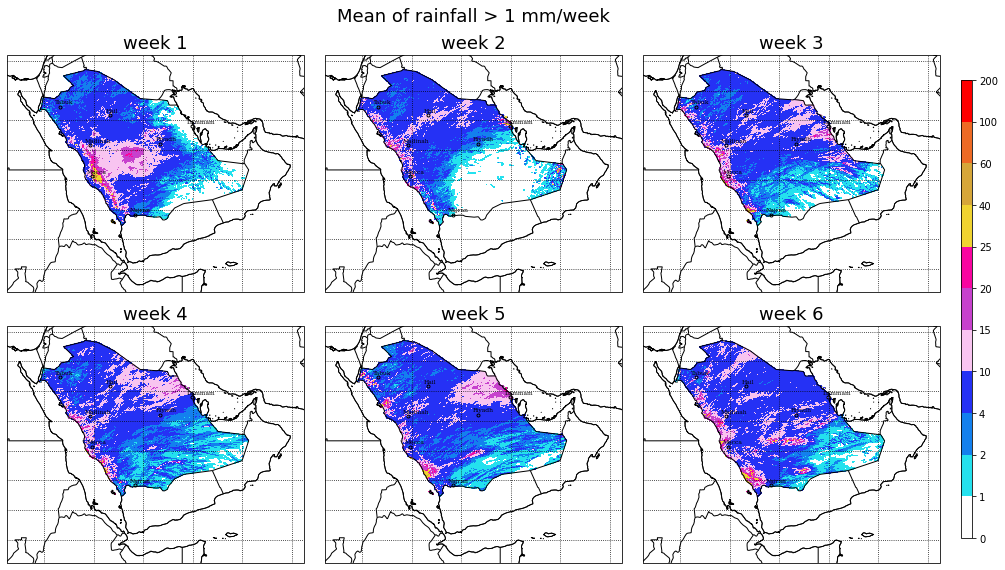

In [11]:
## plot
plot_mean(emean,'Mean',thres,' (%)',levels)